In [94]:
import sys
sys.path.append('../')

In [95]:
import pennylane as qml 
from pennylane import numpy as np 
import matplotlib.pyplot as plt 
from main import arbitrary_state, VarFourier
import numpy

(-6.0, 6.0)

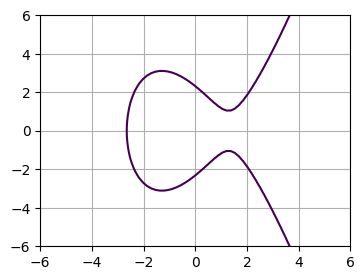

In [144]:
a = 0.2
b = -1
c = 1.07699681e+00
m = 1/2

y, x = numpy.ogrid[-8:8:100j, -8:8:100j]
plt.figure( figsize=(4,3) )
plt.contour( x.ravel(), y.ravel(), 
            y**2 - a*x**3 - b * x  - c, [0] )
plt.grid()
plt.xlim( -6, 6)
plt.ylim( -6, 6)

In [145]:
num_qubits = 4

In [146]:
def init_state():
    pass 
    # for k in range(num_qubits):
    #     qml.PauliX(k)

In [147]:
num_layers = 1
var_state_class = arbitrary_state(num_qubits,num_layers)
var_state = var_state_class.construct_circuit

num_params = var_state_class.num_params
num_params

16

(<Figure size 400x500 with 1 Axes>, <Axes: >)

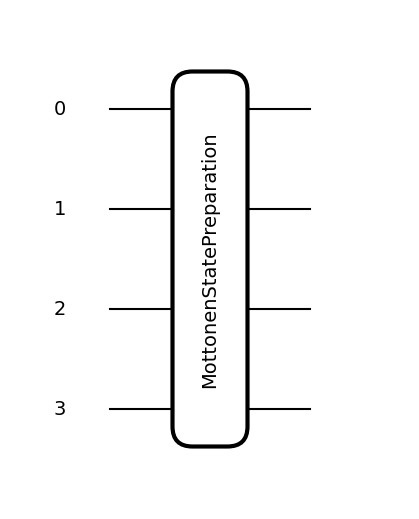

In [148]:
qml.draw_mpl( var_state )( num_params*[1] )

In [149]:
device = qml.device( "lightning.qubit", 
                    wires=num_qubits)

varqft = VarFourier( num_qubits,
                    lambda x : ( -x**3 - b*x ),
                    lambda p : p**2/(2*m),
                    device,
                    var_state  = var_state,
                    init_state = init_state,
                    xmin=-8,
                    xmax= 8,
                    tarjet_energy = c 
                    )

In [150]:
vals, vecs = varqft.energy_eigens()
idx_tarjet = np.argmin( np.abs( c- np.array(vals) ) )
val = vals[idx_tarjet]
vec = vecs[:,idx_tarjet]
val, c, vals

(1.0769968061862745,
 1.07699681,
 array([-5.01108125e+02, -3.23453842e+02, -1.93149042e+02, -1.02899980e+02,
        -4.54346245e+01, -1.35188200e+01, -3.59696785e-01,  1.07699681e+00,
         4.19224580e+00,  6.72316565e+00,  1.93675989e+01,  5.12650288e+01,
         1.08728589e+02,  1.98977308e+02,  3.29281936e+02,  5.06936468e+02]))

In [151]:
varqft.energy_eval( vec )

1.4676285096362073e-17

In [160]:
np.random.seed(101)
params_init = vec.real + np.random.randn( num_params )*0.1
params_init = params_init / np.linalg.norm( params_init )
varqft.energy_eval( params_init )

887.9335889689931

In [169]:
params_ground, energies_ground = varqft.run( params_init, 
                                            max_iterations = 1000, 
                                            learning_rate  = 0.1,
                                            postprocessing = lambda x : x/np.linalg.norm(x),
                                            step_print=1 )

c:\Users\lucia\miniconda3\envs\pennylane\Lib\site-packages\jax\_src\numpy\array_methods.py:271: RuntimeWarning: overflow encountered in cast
  return binary_op(*args)


Step = 0,  Energy = 887.93310547
Step = 1,  Energy = 887.93310547


In [162]:
np.min(energies_ground)

887.93310546875

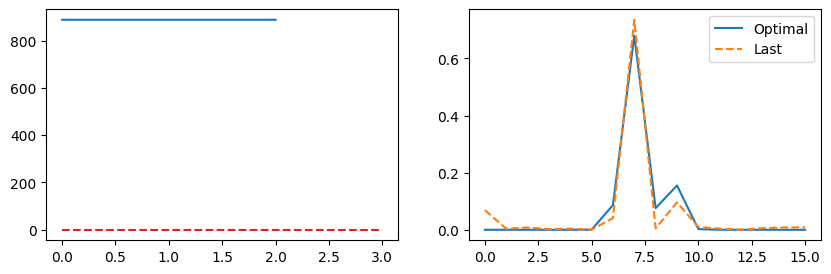

In [168]:
fig, ax = plt.subplots( 1, 2, figsize=(10,3) ) 

ax[0].plot( energies_ground )
ax[0].hlines( 0, 0, len(energies_ground), colors='tab:red', linestyles='--' ) 

ground_state = varqft.state( params_ground[np.argmin(energies_ground)] )
last_state = varqft.state( params_ground[-1] )

ax[1].plot( np.abs(vec)**2) 
ax[1].plot( np.abs(last_state)**2, '--' ) 
ax[1].plot( np.abs(ground_state)**2, '--' ) 
ax[1].legend(['Optimal','Last','Best']) 

In [164]:
fid = np.abs( vecs.T.conj()@last_state )**2
fid, fid[idx_tarjet]

(tensor([8.4893806e-03, 8.5498998e-03, 5.1271506e-03, 3.1776822e-04,
         3.1629961e-03, 4.4037253e-03, 1.4927770e-03, 8.3371764e-01,
         1.1637549e-02, 3.6653508e-02, 7.6938843e-05, 4.0757074e-03,
         2.3899213e-03, 7.6502208e-03, 3.8989240e-03, 6.8355910e-02],
        dtype=float32, requires_grad=True),
 tensor(0.83371764, dtype=float32, requires_grad=True))